In [12]:
import os
import numpy as np 
import pandas as pd
import scipy.io
import warnings 
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from scipy import signal
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from scipy.signal import find_peaks, peak_prominences
import numpy as np
from scipy.signal import argrelmax, argrelmin
from detecta import detect_peaks

In [2]:
def Load_record(Record_number):
    test_sample = scipy.io.loadmat(f'data/part_{Record_number}.mat')['p']
    return test_sample

In [3]:
ecg = []
ppg = []
bp = []
size = 125 #sample size
parts = [1]#,2,3,4,5,6,7,8,9,10,11,12]

for j in parts:
    test_sample=Load_record(j)
    for i in range(1000):      
        temp_mat = test_sample[0, i]
        temp_length = temp_mat.shape[1]
        for j in range((int)(temp_length/size)):
            temp_ecg = temp_mat[2, j*size:(j+1)*size]
            temp_bp = temp_mat[1, j*size:(j+1)*size]
            temp_ppg = temp_mat[0, j*size:(j+1)*size]

                       
            ecg.append(temp_ecg)
            ppg.append(temp_ppg)
            bp.append(temp_bp)

In [ ]:
#ppg, ecg, bp = np.array(ppg).reshape(-1,1), np.array(ecg).reshape(-1,1), np.array(bp).reshape(-1,1)
#print(f'PPG_shape: {ppg.shape}\nECG_shape: {ecg.shape}\nBP_shape: {bp.shape}')


## Feature extraction 

In [86]:
def calculate_statistics(list_values):
    Vmax = list_values.max()
    Vmin = list_values.min()
    m=[Vmin,Vmax]
    distances = np.diff(m)
    distancesV=distances.tolist()
    n5 = np.nanpercentile(list_values, 5)
    n10 = np.nanpercentile(list_values, 10)
    n25 = np.nanpercentile(list_values, 25)
    n33 = np.nanpercentile(list_values, 33)
    n50 = np.nanpercentile(list_values, 50)
    n66 = np.nanpercentile(list_values, 66)
    n75 = np.nanpercentile(list_values, 75)
    n90 = np.nanpercentile(list_values, 90)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    sum_ = np.nansum(list_values)
    return [n5,n10, n25,n33,n50,n66, n75,n90, n95, median, mean, std, var, rms,sum_,Vmax,Vmin,distancesV[0]]

def Extract_ppg50(single_waveform, sample_rate=125):
    def __next_pow2(x):
        return 1<<(x-1).bit_length()
    features = []
    maxima_index = argrelmax(np.array(single_waveform))[0]
    minima_index = argrelmin(np.array(single_waveform))[0]
    derivative_1 = np.diff(single_waveform, n=1) * float(sample_rate)
    derivative_1_maxima_index = argrelmax(np.array(derivative_1))[0]
    derivative_1_minima_index = argrelmin(np.array(derivative_1))[0]
    derivative_2 = np.diff(single_waveform, n=2) * float(sample_rate)
    derivative_2_maxima_index = argrelmax(np.array(derivative_2))[0]
    derivative_2_minima_index = argrelmin(np.array(derivative_2))[0]
    sp_mag = np.abs(np.fft.fft(single_waveform, n=__next_pow2(len(single_waveform))*16))
    freqs = np.fft.fftfreq(len(sp_mag))
    sp_mag_maxima_index = argrelmax(sp_mag)[0]
    # x
    x = single_waveform[maxima_index[0]]
    features.append(x)
    # y
    y = single_waveform[maxima_index[1]]
    features.append(y)
    # z
    z = single_waveform[minima_index[0]]
    features.append(z)
    # t_pi
    t_pi = float(len(single_waveform)) / float(sample_rate)
    features.append(t_pi)
    # y/x
    features.append(y / x)
    # (x-y)/x
    features.append((x - y) / x)
    # z/x
    features.append(z / x)
    # (y-z)/x
    features.append((y - z) / x)
    # t_1
    t_1 = float(maxima_index[0] + 1) / float(sample_rate)
    features.append(t_1)
    # t_2
    t_2 = float(minima_index[0] + 1) / float(sample_rate)
    features.append(t_2)
    # t_3
    t_3 = float(maxima_index[1] + 1) / float(sample_rate)
    features.append(t_3)
    # delta_t
    delta_t = t_3 - t_2
    features.append(delta_t)
    # width
    single_waveform_halfmax = max(single_waveform) / 2
    
    width = 0
    for value in single_waveform[maxima_index[0]::-1]:
        if value >= single_waveform_halfmax:
            width += 1
        else:
            break
    
    for value in single_waveform[maxima_index[0]+1:]:
        if value >= single_waveform_halfmax:
            width += 1
        else:
            break  
    
    features.append(float(width) / float(sample_rate))
    # A_2/A_1
    features.append(sum(single_waveform[:maxima_index[0]]) / sum(single_waveform[maxima_index[0]:]))
    # t_1/x
    features.append(t_1 / x)
    # y/(t_pi-t_3)
    features.append(y / (t_pi - t_3))
    # t_1/t_pi
    features.append(t_1 / t_pi)
    # t_2/t_pi
    features.append(t_2 / t_pi)
    # t_3/t_pi
    features.append(t_3 / t_pi)
    # delta_t/t_pi
    features.append(delta_t / t_pi)
    # t_a1
    t_a1 = float(derivative_1_maxima_index[0]) / float(sample_rate)
    features.append(t_a1)
    # t_b1
    t_b1 = float(derivative_1_minima_index[0]) / float(sample_rate)
    features.append(t_b1)
    # t_e1
    t_e1 = float(derivative_1_maxima_index[1]) / float(sample_rate)
    features.append(t_e1)
    # t_f1
    t_f1 = float(derivative_1_minima_index[1]) / float(sample_rate)
    features.append(t_f1)
    # b_2/a_2
    a_2 = derivative_2[derivative_2_maxima_index[0]]
    b_2 = derivative_2[derivative_2_minima_index[0]]
    features.append(b_2 / a_2)
    # e_2/a_2
    e_2 = derivative_2[derivative_2_maxima_index[1]]
    features.append(e_2 / a_2)
    # (b_2+e_2)/a_2
    features.append((b_2 + e_2) / a_2)
    # t_a2
    t_a2 = float(derivative_2_maxima_index[0]) / float(sample_rate)
    features.append(t_a2)
    # t_b2
    t_b2 = float(derivative_2_minima_index[0]) / float(sample_rate)
    features.append(t_b2)
    # t_a1/t_pi
    features.append(t_a1 / t_pi)
    # t_b1/t_pi
    features.append(t_b1 / t_pi)
    # t_e1/t_pi
    features.append(t_e1 / t_pi)
    # t_f1/t_pi
    features.append(t_f1 / t_pi)
    # t_a2/t_pi
    features.append(t_a2 / t_pi)
    # t_b2/t_pi
    features.append(t_b2 / t_pi)
    # (t_a1-t_a2)/t_pi
    features.append((t_a1 - t_a2) / t_pi)
    # (t_b1-t_b2)/t_pi
    features.append((t_b1 - t_b2) / t_pi)
    # (t_e1-t_2)/t_pi
    features.append((t_e1 - t_2) / t_pi)
    # (t_f1-t_3)/t_pi
    features.append((t_f1 - t_3) / t_pi)
    # f_base
    f_base = freqs[sp_mag_maxima_index[0]] * sample_rate
    features.append(f_base)
    # sp_mag_base
    sp_mag_base = sp_mag[sp_mag_maxima_index[0]] / len(single_waveform)
    features.append(sp_mag_base)
    # f_2
    f_2 = freqs[sp_mag_maxima_index[1]] * sample_rate
    features.append(f_2)
    # sp_mag_2
    sp_mag_2 = sp_mag[sp_mag_maxima_index[1]] / len(single_waveform)
    features.append(sp_mag_2)
    # f_3
    f_3 = freqs[sp_mag_maxima_index[2]] * sample_rate
    features.append(f_3)
    # sp_mag_3
    sp_mag_3 = sp_mag[sp_mag_maxima_index[2]] / len(single_waveform)
    features.append(sp_mag_3)
     # A_1
    features.append(sum(single_waveform[maxima_index[0]:]))
    # A_2
    features.append(sum(single_waveform[:maxima_index[0]]))  
   
    peak_n =detect_peaks(single_waveform, mph=0, mpd=10, show=False)
    list_peaks=peak_n.tolist()
    distance=[abs(v - (list_peaks+[list_peaks[0]])[i+1]) for i, v in enumerate(list_peaks)]
    features.append(distance[1])
   
    return features


def extract_svri(single_waveform):
    def __scale(data):
        data_max = max(data)
        data_min = min(data)
        return [(x - data_min) / (data_max - data_min) for x in data]
    max_index = np.argmax(single_waveform)
    single_waveform_scaled = __scale(single_waveform)
    return np.mean(single_waveform_scaled[max_index:]) / np.mean(single_waveform_scaled[:max_index])

In [110]:
All_Features=[]
for i in ppg:
    print(i)   
    data=i.reshape(i.size)   
    Time_frequence=Extract_ppg50(i)
    print(Time_frequence)
    print("")
    #scaled_Mean=extract_svri(data)
    #statistical=calculate_statistics(i)
    All_Features.append(Time_frequence)
    #All_Features.append(scaled_Mean)
    #All_Features.append(statistical)
    

[1.75953079 1.71847507 1.68426197 1.65786901 1.63734115 1.61583578
 1.59335288 1.57086999 1.54936461 1.52688172 1.50342131 1.47898338
 1.45356794 1.42815249 1.40273705 1.3773216  1.35777126 1.34115347
 1.32355816 1.30596285 1.28836755 1.27174976 1.25806452 1.24340176
 1.228739   1.21212121 1.19354839 1.17302053 1.15835777 1.15249267
 1.15835777 1.18963832 1.26099707 1.37829912 1.54154448 1.73802542
 1.9540567  2.17106549 2.37047898 2.53958944 2.67253177 2.76148583
 2.82404692 2.87585533 2.90615836 2.91788856 2.91495601 2.89931574
 2.87194526 2.83284457 2.78103617 2.71652004 2.64125122 2.56500489
 2.485826   2.39296188 2.29227761 2.18963832 2.08993157 1.99608993
 1.91300098 1.84066471 1.77908113 1.72922776 1.68817204 1.65493646
 1.63147605 1.61290323 1.59335288 1.57282502 1.55131965 1.52883675
 1.50537634 1.4799609  1.45552297 1.43010753 1.40469208 1.38025415
 1.36265885 1.34799609 1.33040078 1.31085044 1.29325513 1.27761486
 1.26197458 1.24731183 1.23167155 1.21505376 1.19648094 1.1739

IndexError: index 1 is out of bounds for axis 0 with size 1

In [94]:
#All_Features
data=ppg[2:]
data

[array([1.61974585, 1.59335288, 1.57282502, 1.55816227, 1.54447703,
        1.52883675, 1.51319648, 1.49657869, 1.47800587, 1.45845552,
        1.43890518, 1.4173998 , 1.39589443, 1.37634409, 1.35777126,
        1.34506354, 1.33431085, 1.32160313, 1.30889541, 1.2971652 ,
        1.28641251, 1.27565982, 1.2629521 , 1.24731183, 1.22776149,
        1.20527859, 1.18475073, 1.17497556, 1.18377322, 1.2170088 ,
        1.28934506, 1.40860215, 1.57282502, 1.771261  , 1.98729228,
        2.20039101, 2.39589443, 2.5601173 , 2.68817204, 2.77908113,
        2.83382209, 2.86217009, 2.87585533, 2.87585533, 2.86314761,
        2.83968719, 2.8054741 , 2.76050831, 2.71652004, 2.66568915,
        2.5943304 , 2.51026393, 2.41642229, 2.32746823, 2.24340176,
        2.15347019, 2.06353861, 1.97947214, 1.90518084, 1.84164223,
        1.78787879, 1.74389052, 1.7086999 , 1.67839687, 1.65200391,
        1.63147605, 1.61388074, 1.59335288, 1.57086999, 1.54643206,
        1.52101662, 1.49462366, 1.46823069, 1.44

In [104]:
ppg[1].shape

(125,)

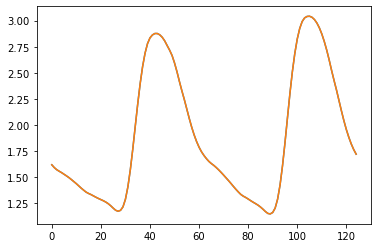

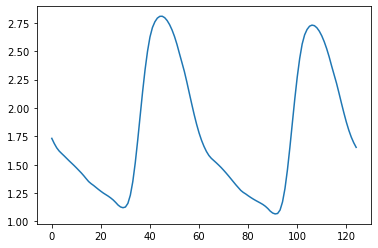

In [108]:
dd=[1.61974585, 1.59335288, 1.57282502, 1.55816227, 1.54447703,
       1.52883675, 1.51319648, 1.49657869, 1.47800587, 1.45845552,
       1.43890518, 1.4173998 , 1.39589443, 1.37634409, 1.35777126,
       1.34506354, 1.33431085, 1.32160313, 1.30889541, 1.2971652 ,
       1.28641251, 1.27565982, 1.2629521 , 1.24731183, 1.22776149,
       1.20527859, 1.18475073, 1.17497556, 1.18377322, 1.2170088 ,
       1.28934506, 1.40860215, 1.57282502, 1.771261  , 1.98729228,
       2.20039101, 2.39589443, 2.5601173 , 2.68817204, 2.77908113,
       2.83382209, 2.86217009, 2.87585533, 2.87585533, 2.86314761,
       2.83968719, 2.8054741 , 2.76050831, 2.71652004, 2.66568915,
       2.5943304 , 2.51026393, 2.41642229, 2.32746823, 2.24340176,
       2.15347019, 2.06353861, 1.97947214, 1.90518084, 1.84164223,
       1.78787879, 1.74389052, 1.7086999 , 1.67839687, 1.65200391,
       1.63147605, 1.61388074, 1.59335288, 1.57086999, 1.54643206,
       1.52101662, 1.49462366, 1.46823069, 1.44086022, 1.41251222,
       1.38514174, 1.3597263 , 1.33626588, 1.31964809, 1.30694037,
       1.29227761, 1.27663734, 1.26197458, 1.24828935, 1.23362659,
       1.21603128, 1.19550342, 1.17302053, 1.1544477 , 1.14956012,
       1.16324536, 1.20527859, 1.2913001 , 1.42717498, 1.61094819,
       1.82991202, 2.06549365, 2.29814272, 2.5083089 , 2.68426197,
       2.8230694 , 2.92375367, 2.99022483, 3.02541544, 3.03910068,
       3.04105572, 3.03128055, 3.00977517, 2.97653959, 2.93059629,
       2.87194526, 2.80058651, 2.71749756, 2.62365591, 2.52199413,
       2.42619746, 2.33431085, 2.23460411, 2.13587488, 2.04203324,
       1.95698925, 1.88367546, 1.81915934, 1.76539589, 1.72140762]
plt.plot(ppg[2])
plt.plot(dd)
plt.show()
plt.plot(ppg[1])

plt.show()